In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
import string
import nltk

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

data = pd.read_csv("spam1.csv")
data.columns = ['labels','body_text']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")),3)*100
    

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x : count_punct(x))

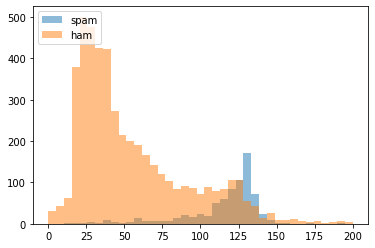

In [12]:
from matplotlib import pyplot

bins = np.linspace(0,200,40)

pyplot.hist(data[data['labels']=='spam']['body_len'], bins, alpha=0.5,  label='spam')
pyplot.hist(data[data['labels']=='ham']['body_len'], bins, alpha=0.5, label='ham')
pyplot.legend(loc='upper left')

pyplot.show()

In [8]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])


X_features = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)


In [10]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, data['labels'], test_size=0.2)

def train_RF(n_est, depth):
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    #sorted(zip(rf_model.feature_importances, X_train.columns), reverse=True)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')
    print('Estimators: {} / Depth: {} -- Precision: {} / Recall: {} / Accuracy: {}'.format(
            n_est, depth, round(precision, 3), round(recall, 3),
            round((y_pred==y_test).sum()/len(y_pred),3)))
    

In [11]:
for n_est in [10,50,100]:
    for depth in [10,20,30,None]:
        train_RF(n_est, depth)

Estimators: 10 / Depth: 10 -- Precision: 1.0 / Recall: 0.293 / Accuracy: 0.911
Estimators: 10 / Depth: 20 -- Precision: 0.987 / Recall: 0.543 / Accuracy: 0.942
Estimators: 10 / Depth: 30 -- Precision: 1.0 / Recall: 0.629 / Accuracy: 0.953
Estimators: 10 / Depth: None -- Precision: 1.0 / Recall: 0.764 / Accuracy: 0.97
Estimators: 50 / Depth: 10 -- Precision: 1.0 / Recall: 0.236 / Accuracy: 0.904
Estimators: 50 / Depth: 20 -- Precision: 1.0 / Recall: 0.593 / Accuracy: 0.949
Estimators: 50 / Depth: 30 -- Precision: 1.0 / Recall: 0.7 / Accuracy: 0.962
Estimators: 50 / Depth: None -- Precision: 0.991 / Recall: 0.821 / Accuracy: 0.977
Estimators: 100 / Depth: 10 -- Precision: 1.0 / Recall: 0.286 / Accuracy: 0.91
Estimators: 100 / Depth: 20 -- Precision: 1.0 / Recall: 0.607 / Accuracy: 0.951
Estimators: 100 / Depth: 30 -- Precision: 1.0 / Recall: 0.693 / Accuracy: 0.961
Estimators: 100 / Depth: None -- Precision: 1.0 / Recall: 0.821 / Accuracy: 0.978
